# PRÀCTICA 2: IDENTIFICACIÓ DE SENTIMENTS

Irene Pumares i Anna Casanovas

Descarreguem el dataset i les llibreries necessàries per fer el treball.

In [2]:
# Importem el corpus
import nltk
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews as mr

# Per fer preprocess dels textos
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('wordnet') # Organitza paraules en conjunts de synsets
nltk.download('omw-1.4') # Per utilitzar el Lesk de NLTK

nltk.download('punkt') # Tokenitzador
nltk.download('averaged_perceptron_tagger') # Etiquetador POS
nltk.download('sentiwordnet')

from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


In [3]:
# Coses necessàries a importar per fer els models:

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import List
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

PREPROCESSAMENT DE LES DADES

In [4]:
def preprocess(text: str) -> str:

  """
  Fa un preprocess del text donat: eliminant numeros, signes de puntuació,
  eliminant stopwords i passant el text a minúscules.

  Arguments:
        text (str): La review que volguem preprocessar

  Retorna:
        str: La review preprocessada
  """

  stop_words = set(stopwords.words('english'))
  text = re.sub(r'\d', '', text)
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text)

  words = text.split()
  words = [word for word in words if word not in stop_words]
  preprocessed_text = ' '.join(words)

  return preprocessed_text

Apliquem aquesta funció de preprocés a cada una de les reviews (ja sigui positiva o negativa). Guardem tots els textos a un diccionari.

In [5]:
text_pos_preprocessat = []
text_neg_preprocessat = []

for i in range(1000):
  review_pos = mr.raw(mr.fileids('pos')[i])
  review_neg = mr.raw(mr.fileids('neg')[i])
  text_pos_preprocessat.append(preprocess(review_pos))
  text_neg_preprocessat.append(preprocess(review_neg))

dades_total = {1: text_pos_preprocessat, 0: text_neg_preprocessat}

Dividim les dades en conjunt de train i test, i creem un vector amb les etiquetes corresponents.

In [6]:
train_data_pos, test_data_pos = train_test_split(dades_total[1], test_size=0.3, random_state=42)
train_data_neg, test_data_neg = train_test_split(dades_total[0], test_size=0.3, random_state=42)

train_labels_pos = [1] * len(train_data_pos)
test_labels_pos = [1] * len(test_data_pos)
train_labels_neg = [0] * len(train_data_neg)
test_labels_neg = [0] * len(test_data_neg)

train_data = train_data_pos + train_data_neg
test_data = test_data_pos + test_data_neg
train_labels = train_labels_pos + train_labels_neg
test_labels = test_labels_pos + test_labels_neg

Per acabar el preprocessament, farem ús del **CountVectorizer** que passa un text a una matriu de conteig de tokens.

In [7]:
train_data_shuffled, train_labels_shuffled = shuffle(train_data, train_labels, random_state=42)
test_data_shuffled, test_labels_shuffled = shuffle(test_data, test_labels, random_state=42)

vectorizer_shuffled = CountVectorizer()

train_data_features = vectorizer_shuffled.fit_transform(train_data_shuffled)
test_data_features = vectorizer_shuffled.transform(test_data_shuffled)

# Train_data_features seran les matrius utilitzades per entrenar el model


A partir d'ara les dades que utilitzarem pel model passades pel CountVectorizer seran **Train_data_features**

In [8]:
def matriu_de_confusio(y_true: List[int], y_pred: List[int], labels: List[str] = ['Negative', 'Positive']) -> None:

    """
    Dibuixa la matriu de confusió del model de classificació actual.

    Arguments:
        y_true (List[int]): Llista amb els valors de veritat
        y_pred (List[int]): Llista dels valors predits
        labels (List[str]): Noms de les etiquetes, en el nostre cas: ['Negative', 'Positive'].
    """

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


# A. DETECCIÓ D'OPINIONS AMB ALGORISMES D'APRENENTATGE SUPERVISAT

Amb les nostres dades preprocessades, farem diferents models d'aprenentatge supervisat per veure com classifiquen els dades i quins resultats donen millor.

### 1. LOGISTIC REGRESSION

Busquem els millors hiperparàmetres per fer la regressió logística i ho fem utilitzant el f1-score com a mètrica.

In [ ]:
parametres_logistic = {
    'max_iter': [100, 300, 600, 1000],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'random_state': [42]
}

classificador_logistic = LogisticRegression()

grid_search_logistic = GridSearchCV(estimator=classificador_logistic,
                           param_grid=parametres_logistic,
                           cv=3,
                           scoring='f1',
                           verbose=1)

grid_search_logistic.fit(train_data_features, train_labels_shuffled)

print("LOGISTIC REGRESSION: ")
print("Best hyperparameters: ", grid_search_logistic.best_params_)
print("Best F1 score: ", grid_search_logistic.best_score_)

Entrenem el model amb els hiperparàmetres triats i observem els resultats.

In [ ]:
classificador_logistic = LogisticRegression(random_state=42, C=0.1, max_iter=100)
classificador_logistic.fit(train_data_features, train_labels_shuffled)

y_pred_logistic = classificador_logistic.predict(test_data_features)

print("RESULTATS LOGISTIC REGRESSION: \n")
print("Accuracy:", accuracy_score(test_labels_shuffled, y_pred_logistic))
print("\nClassification Report:\n", classification_report(test_labels_shuffled, y_pred_logistic))

RESULTATS LOGISTIC REGRESSION: 

Accuracy: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       300
           1       0.84      0.82      0.83       300

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



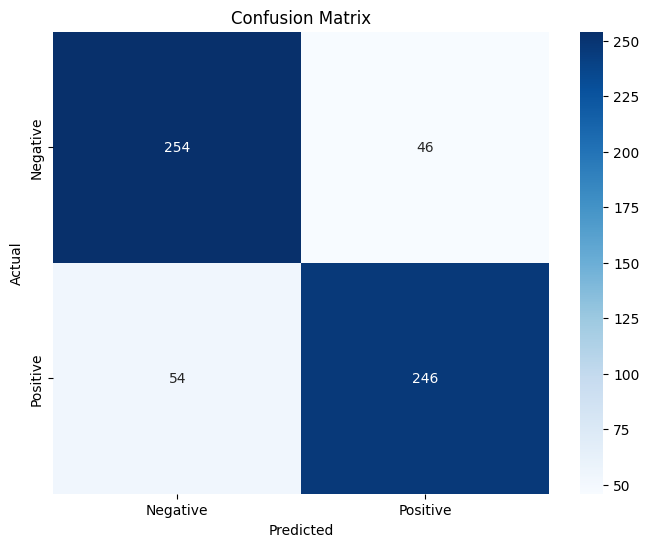

In [ ]:
matriu_de_confusio(test_labels_shuffled, y_pred_logistic)

### 2. RANDOM FOREST

Utilitzem gridSearch com abans per trobar els millors paràmetres i tenir bons resultats.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
parametres_randforest = {
    'n_estimators': [5, 10, 20, 50, 80, 100],
    'min_samples_split': [2, 5, 7, 8, 9, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8, 9, 10],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [2, 5, 8, 9, 10],
    'bootstrap': [True, False],
    'random_state': [42]}

classificador_randforest = RandomForestClassifier()

grid_search_randforest = GridSearchCV(estimator = classificador_randforest, param_grid = parametres_randforest, cv = 3)

grid_search_randforest.fit(train_data_features, train_labels_shuffled)

print("RANDOM FOREST: ")
print("Best hyperparameters: ", grid_search_randforest.best_params_)

Entrenem el random forest i observem els resultats.

RESULTATS RANDOM FOREST: 

Accuracy: 0.7983333333333333
F1 Score: 0.7952622673434855

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       300
           1       0.81      0.78      0.80       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



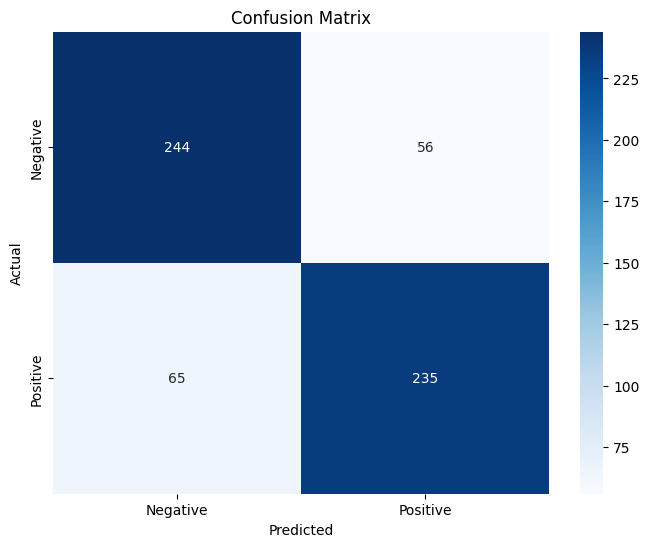

In [ ]:
classificador_randforest = RandomForestClassifier(random_state = 42, bootstrap = False, max_depth =  10, max_features= 'sqrt', min_samples_leaf = 1, min_samples_split= 10, n_estimators= 100)
classificador_randforest.fit(train_data_features, train_labels_shuffled)

y_pred_randforest = classificador_randforest.predict(test_data_features)
f1 = f1_score(test_labels_shuffled, y_pred_randforest, average='binary')

print("RESULTATS RANDOM FOREST: \n")
print("Accuracy:", accuracy_score(test_labels_shuffled, y_pred_randforest))
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report(test_labels_shuffled, y_pred_randforest))

matriu_de_confusio(test_labels_shuffled, y_pred_randforest)

### 3. NAIVE BAYES

Probem també l'algorisme après a classe Naive Bayes.

RESULTATS NAIVE BAYES: 

Accuracy: 0.7983333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       300
           1       0.81      0.79      0.80       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



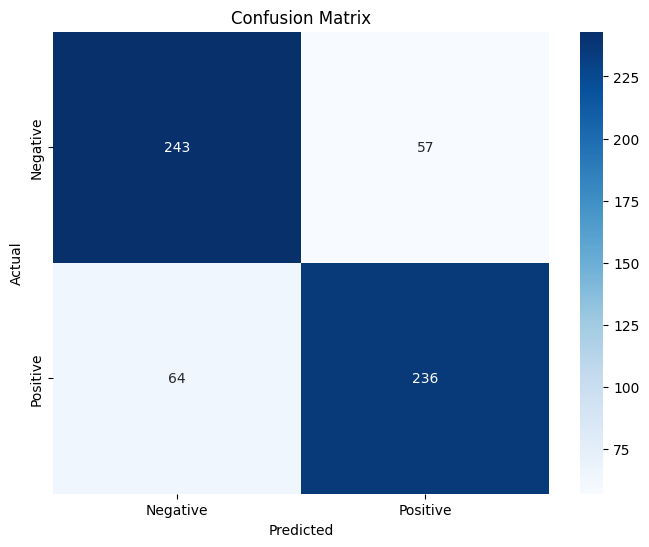

In [ ]:
classificador_naivbayes = MultinomialNB()
classificador_naivbayes.fit(train_data_features, train_labels_shuffled)
y_pred_naivbayes = classificador_naivbayes.predict(test_data_features)

print("RESULTATS NAIVE BAYES: \n")
print("Accuracy:", accuracy_score(test_labels_shuffled, y_pred_naivbayes))
print("\nClassification Report:\n", classification_report(test_labels_shuffled, y_pred_naivbayes))

matriu_de_confusio(test_labels_shuffled, y_pred_naivbayes)

### 4. SVM

RESULTATS SVM: 

Accuracy: 0.8133333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       300
           1       0.82      0.80      0.81       300

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600



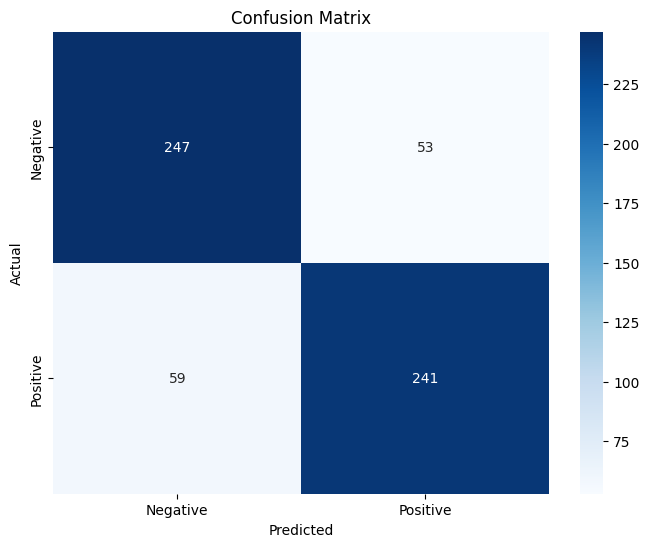

In [ ]:
classificador_svm = SVC(kernel='linear')
classificador_svm.fit(train_data_features, train_labels_shuffled)

y_pred_svm = classificador_svm.predict(test_data_features)

print("RESULTATS SVM: \n")
print("Accuracy:", accuracy_score(test_labels_shuffled, y_pred_svm))
print("\nClassification Report:\n", classification_report(test_labels_shuffled, y_pred_svm))

matriu_de_confusio(test_labels_shuffled, y_pred_svm)

### 5. XGBOOST

In [ ]:
parametres_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 1, 5]
}

classificador_xgb = XGBClassifier()

grid_search_xgb = GridSearchCV(estimator=classificador_xgb,
                        param_grid=parametres_xgb,
                        cv=3,
                        scoring='f1',
                        )

grid_search_xgb.fit(train_data_features, train_labels_shuffled)

print("XGBOOST: ")
print('Best hyperparameters:', grid_search_xgb.best_params_)
print('Best F1 score:', grid_search_xgb.best_score_)

Entrenem el model

RESULTATS XGBOOST: 

Accuracy: 0.7966666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80       300
           1       0.81      0.78      0.79       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



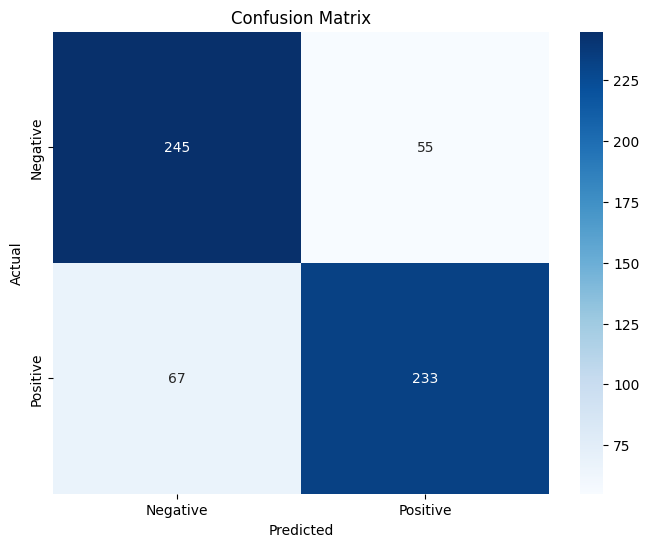

In [ ]:
classificador_xgb = XGBClassifier(gamma = 0, learning_rate = 0.1, max_depth = 3, n_estimators = 200, random_state = 42)

classificador_xgb.fit(train_data_features, train_labels_shuffled)
y_pred_xgb = classificador_xgb.predict(test_data_features)

print("RESULTATS XGBOOST: \n")
print("Accuracy:", accuracy_score(test_labels_shuffled, y_pred_xgb))
print("\nClassification Report:\n", classification_report(test_labels_shuffled, y_pred_xgb))

matriu_de_confusio(test_labels_shuffled, y_pred_xgb)


# B. DETECCIÓ D'OPINIONS AMB MODEL D'APRENENTATGE NO SUPERVISAT

S'utilitzarà Lesk, i sentiwordnet per desambiguar les paraules i trobarli un valor positiu o negatiu als synsets.

In [9]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.corpus import movie_reviews as mr
from nltk.wsd import lesk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from typing import Optional, List, Dict

In [10]:
wnl = WordNetLemmatizer()

def lemmatize(p: tuple) -> Optional[str]:

  """
  Funció que donada una POS tag ens retorna la seva categoria lematitzada.
  Arguments:
      p (tuple): Tupla que conté la paraula actual i la seva POS tag.
  Retorna:
      La categoria corresponent a la POS tag, i si no la troba retorna None.
  """

  d = {'NN': 'n', 'NNS': 'n',
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}

  return d.get(p[1], None)

def agafar_tipus_paraules(text: str, tipos: List[str]) -> Dict[str, List[str]]:

    """
    Extreu només les paraules de tipus específics de paraules.
    Arguments:
        text (str): La review de la que volem extreure les paraules
        tipos (List[str]): Llista dels tipus de paraules que volem extreure del text (['a', 'n']...)
    Retorna:
        Dict[str, List[str]]: Diccionari on les claus són els tipus de paraules i els valors
          una llista de les paraules corresponents a cada tipus del text
    """

    paraules = nltk.word_tokenize(text)
    pos_paraules = nltk.pos_tag(paraules)

    paraules_per_tipus = {tipo: [] for tipo in tipos}

    for paraula, pos in pos_paraules:
        tipus_abreviat = lemmatize((paraula, pos))
        if tipus_abreviat in tipos:
            paraules_per_tipus[tipus_abreviat].append(paraula)

    return paraules_per_tipus


In [ ]:
def analitzar_sentiment(review: str, tipos: List[str], l: float) -> int:

    """
    Analitza si la opinió d'una review és positiva o negativa a partir de certes paraules de categories específiques.
    Arguments:
        review(str): El text
        tipos: Llista dels tipus de paraules que volem utilitzar per saber la opinió.
        l (float): Un factor que es multiplicarà pel sentiment negatiu per ajustar el llindar d'identificació d'una review positiva o negativa
    """

    palabras_por_tipo = agafar_tipus_paraules(review, tipos)
    palabras_relevantes = []
    for tipo in tipos:
        palabras_relevantes.extend(palabras_por_tipo.get(tipo, []))

    pos_rating = 0
    neg_rating = 0

    for palabra in palabras_relevantes:
        for tipo in tipos:
            synset = lesk(review, palabra, tipo)
            if synset:
                sentiSynset = swn.senti_synset(synset.name())
                if sentiSynset: # Ignorem la paraula si no trobem un sentiSynset associat.
                    pos_rating += sentiSynset.pos_score()
                    neg_rating += sentiSynset.neg_score() * l  # Afegim ponderació
                break

    if pos_rating > neg_rating:
        return 1
    else:
        return 0


Calculem la combinació que doni millors resultats

In [ ]:
from itertools import combinations
from sklearn.metrics import f1_score

tipos_base = ['a', 'n', 'v', 'r']
combinacions = []

for i in range(1, len(tipos_base) + 1):
    combinacions.extend(combinations(tipos_base, i))

def calcular_f1_para_combinacion(combinacio):
    resultados = [analitzar_sentiment(review, list(combinacio)) for review in train_data]
    return f1_score(train_labels, resultados)

f1_scores = {}
for combinacio in combinacions:
    f1 = calcular_f1_para_combinacion(combinacio)
    f1_scores[combinacio] = f1

millor_combinacio = max(f1_scores, key=f1_scores.get)
mejor_f1 = f1_scores[millor_combinacio]

print("La millor combinacio:", millor_combinacio)

In [12]:
tipus_a_analitzar = ['a', 'v', 'r']
l = 1
resultados = [analitzar_sentiment(review, tipus_a_analitzar, l) for review in train_data]
report = classification_report(train_labels, resultados, target_names=['Negative', 'Positive'])
print(report)
matriu_de_confusio(train_labels, resultados)

              precision    recall  f1-score   support

    Negative       0.75      0.28      0.41       700
    Positive       0.56      0.91      0.69       700

    accuracy                           0.59      1400
   macro avg       0.65      0.59      0.55      1400
weighted avg       0.65      0.59      0.55      1400



Tot i que ens doni el F1 score més alt, veiem que tendeix a classificar bé les positives, però les negatives les classifica molt malament.

Resultats del model final, afegint la PONDERACIÓ

In [ ]:
tipus_a_analitzar = ['a']
l = 1.13
resultados = [analitzar_sentiment(review, tipus_a_analitzar, l) for review in test_data]
report = classification_report(test_labels, resultados, target_names=['Negative', 'Positive'])
print(report)
matriu_de_confusio(test_labels, resultados)